In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

## 1. Load Data and Preparation 

In [2]:
df1 = pd.read_csv('../input/loan_2014_prp.csv', low_memory=False)
df1 = df1[:-2] # The last two rows are invalid

In [3]:
df1.shape

(235629, 105)

### (1) Data selection

In [4]:
all_num_feature = ['inqlast12m', 'secappopenactil', 'verificationstatusjoint', 
                   'allutil', 'openil24m', 'secappchargeoffwithin12mths', 
                   'maxbalbc', 'secappinqlast6mths', 'secappearliestcrline', 
                   'annualincjoint', 'secappmthssincelastmajorderog', 'id', 
                   'openrv12m', 'dtijoint', 'openrv24m', 'secappmortacc', 
                   'memberid', 'openacc6m', 'ilutil', 'secappopenacc', 'totalcutl', 
                   'mthssincercntil', 'totalbalil', 'secapprevolutil', 
                   'secappcollections12mthsexmed', 'inqfi', 'secappnumrevaccts', 
                   'openactil', 'revolbaljoint', 'openil12m']

In [5]:
ob_feature = ['disbursementmethod', 'grade', 'emplength', 'homeownership', 
              'addrstate', 'revolutil', 'earliestcrline', 'subgrade', 'emptitle', 
              'applicationtype', 'purpose', 'zipcode', 'desc', 'verificationstatus',
              'initialliststatus', 'term', 'intrate', 'issued', 'loanstatus']

In [6]:
num_feature = ['dti', 'numactvrevtl', 'totalrevhilim', 'mosinoldrevtlop', 
               'pcttlnvrdlq', 'numbctl', 'avgcurbal', 'installment', 
               'collections12mthsexmed', 'mthssincelastrecord', 'inqlast6mths', 
               'mosinoldilacct', 'delinqamnt', 'mosinrcntrevtlop', 'pubrec', 
               'chargeoffwithin12mths', 'totalbalexmort', 'taxliens', 'numrevaccts', 
               'fundedamnt', 'numtloppast12m', 'accopenpast24mths', 'mosinrcnttl', 
               'loanamnt', 'mthssincerecentinq', 'bcopentobuy', 'totalilhighcreditlimit', 
               'numbcsats', 'mthssincerecentbc', 'numsats', 'numtl120dpd2m', 
               'mthssincerecentbcdlq', 'numtl90gdpd24m', 'totcurbal', 'mthssincelastdelinq', 
               'numactvbctl', 'mthssincelastmajorderog', 'percentbcgt75', 'numoprevtl', 
               'mthssincerecentrevoldelinq', 'totalbclimit', 'numrevtlbalgt0', 
               'tothicredlim', 'bcutil', 'pubrecbankruptcies', 'numacctsever120pd', 
               'openacc', 'revolbal', 'numtl30dpd', 'totalacc', 'accnowdelinq', 'mortacc', 
               'delinq2yrs', 'totcollamt', 'numiltl', 'annualinc']

In [7]:
select_feature = ob_feature + num_feature
len(select_feature)

75

Feature 'applicationtype' only has one value as 'individual'. Feature 'loanamnt' is always the same as feature 'fundedamnt'.  Over 93% of feature 'desc' value is NaN. Feature 'disbursementmethod' has one value as 'Cash'. Remove these features. At the same time, feature 'id','issued' and 'loanstatus' from ob_feature are index, train/test flag and target.

In [8]:
ob_feature.remove('applicationtype')
num_feature.remove('loanamnt')
ob_feature.remove('desc')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')
ob_feature.remove('disbursementmethod')

In [9]:
select_feature = ob_feature+num_feature
len(select_feature)

69

In [10]:
df = df1[select_feature+['loanstatus','issued']]

In [11]:
df.shape

(235629, 71)

### (2) Select 36 months loan and label target

In this work, only term = 36 months, and loanstatus = full paid and charged off are considered, Fully paid is labeled as 0 and charged off is labeled as 1.

In [12]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")
df = df.query("term ==' 36 months'")
df.shape

(161820, 71)

In [13]:
ob_feature.remove('term')

In [14]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [15]:
print(df.loanstatus.value_counts())
print(df.loanstatus.value_counts(normalize=True))

0    139703
1     22117
Name: loanstatus, dtype: int64
0    0.863323
1    0.136677
Name: loanstatus, dtype: float64


### (3) Split 2014 data for training and testing

To train and test the models, we split the 2014 data to 2 parts, training data from Jan. to Sept. and test data from Oct. to Dec. About 30% of data is used as test dataset. 

In [16]:
issued = list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [17]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts()

1    112533
0     49287
Name: train_flg, dtype: int64

## 2. Feature Engineering and Cleaning

### (1) Datetime to numeric feature

Covert feature ealiestcrline, which represents the beginning of credit line history, to number of months till Dec. 2014.

In [18]:
df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Aug-2002', 'Nov-1992', 'Oct-2001', 'Oct-1998'], dtype=object)

In [19]:
cl_month = df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year = df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [20]:
print(cl_month.unique())
print(cl_year.unique())

['Sep' 'Aug' 'Nov' 'Oct' 'May' 'Jul' 'Jan' 'Jun' 'Dec' 'Feb' 'Apr' 'Mar']
[1989 2002 1992 2001 1998 2009 2003 1999 1996 1995 1993 2010 2007 2000 2011
 2008 2006 1997 2004 1988 1994 2005 1987 1991 1985 1986 1973 1982 1984 1976
 1983 1974 1981 1978 1990 1980 1979 1977 1969 1971 1967 1972 1968 1962 1975
 1965 1966 1963 1970 1964 1958 1955 1959 1961 1960 1954 1957 1949 1950 1948
 1953 1956]


In [21]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 
            'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [22]:
df['earliestcrline_month'] = df.earliestcrline.apply(lambda x: (2014-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [23]:
df.earliestcrline_month[:5]

1    303
4    148
5    265
6    158
8    194
Name: earliestcrline_month, dtype: int64

In [24]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')
print(len(ob_feature), len(num_feature))

12 56


### (2) Employment length to numeric feature

In [25]:
print(df['emplength'].isnull().sum())
df['emplength'].unique()

0


array(['8 years', '< 1 year', '10+ years', '2 years', '9 years', '7 years',
       '3 years', '1 year', 'n/a', '4 years', '5 years', '6 years'], dtype=object)

In [26]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [27]:
df.emplength.value_counts()

 10     50933
 2      14594
 3      13041
 0      12995
 1      10519
 4       9619
-999     9587
 5       9109
 7       8897
 6       8182
 8       8084
 9       6260
Name: emplength, dtype: int64

In [28]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print(len(ob_feature), len(num_feature))

11 57


### (3) Percentage to numeric features: intrate and revolutil

In [29]:
intrate = df.intrate.apply(lambda x: float(x.replace('%','')))

In [30]:
df.intrate[0:2]

1      6.99%
4     13.66%
Name: intrate, dtype: object

In [31]:
df.intrate=intrate
df.intrate[:2]

1     6.99
4    13.66
Name: intrate, dtype: float64

In [32]:
df.revolutil[:2]

1    31.6%
4    91.9%
Name: revolutil, dtype: object

In [33]:
revolutil = df.revolutil.apply(lambda x: str(x).replace('%','')).astype(float)

In [34]:
df.revolutil=revolutil
df.revolutil[:2]

1    31.6
4    91.9
Name: revolutil, dtype: float64

In [35]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [36]:
print(len(ob_feature), len(num_feature))

9 59


### (4) Ordinal feature encoding: grade and subgrade

In [37]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [38]:
df.grade = df.grade.map(Dic_grade)

In [39]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [40]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [41]:
print(len(ob_feature), len(num_feature))

7 61


### (5) High cardinality feature encoding

#### (a) Zip code - frequency encoding

In [42]:
print(df.zipcode.nunique(), df.zipcode.unique()[:5])

854 ['937xx' '850xx' '077xx' '554xx' '982xx']


In [43]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [44]:
df.zipcode[:5]

1    937
4    850
5     77
6    554
8    982
Name: zipcode, dtype: int64

In [45]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [46]:
zipcode_freq[0:5]

,zipcode,0
0,8,1
1,10,229
2,11,66
3,12,69
4,13,41


In [47]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [48]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [49]:
df[zipcode_freq.columns][:5]

,zipcode,zipcode_freq
0,937,243
1,850,731
2,77,362
3,554,634
4,982,448


In [50]:
ob_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')

In [51]:
print(len(ob_feature), len(num_feature))

6 63


#### (b) emptitle-frequency encoding (can do some NLP as improvement)

In [52]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")

In [53]:
df[emptitle_freq.columns][0:5]

,emptitle,emptitle_freq
0,Truck Driver Delivery Personel,1.0
1,Technical Specialist,17.0
2,Admin Specialist,5.0
3,Manufacturing Engineer,43.0
4,Teacher,3116.0


In [54]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')

In [55]:
print(len(ob_feature), len(num_feature))

5 64


#### (c) Addr_state - frequency encoding

In [56]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")

In [57]:
df[addrstate_freq.columns][0:5]

,addrstate,addrstate_freq
0,CA,24239
1,AZ,3876
2,NJ,5985
3,MN,2937
4,WA,3551


In [58]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')

In [59]:
print(len(ob_feature), len(num_feature))

4 65


#### (d) One-hot encoding

In [60]:
dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [61]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [62]:
OHE_feature = list(df_dummy.columns.values)

In [63]:
len(OHE_feature)

22

In [64]:
df = pd.concat([df,df_dummy], axis=1 )

In [65]:
df.shape

(161820, 98)

In [66]:
for feat in dummy_feature: 
    ob_feature.remove(feat)
len(ob_feature)

0

In [67]:
select_feature = num_feature+OHE_feature
len(select_feature)

87

## 3. Models

### (1) XGBoost

In [68]:
feat = select_feature
print(feat)

['dti', 'numactvrevtl', 'totalrevhilim', 'mosinoldrevtlop', 'pcttlnvrdlq', 'numbctl', 'avgcurbal', 'installment', 'collections12mthsexmed', 'mthssincelastrecord', 'inqlast6mths', 'mosinoldilacct', 'delinqamnt', 'mosinrcntrevtlop', 'pubrec', 'chargeoffwithin12mths', 'totalbalexmort', 'taxliens', 'numrevaccts', 'fundedamnt', 'numtloppast12m', 'accopenpast24mths', 'mosinrcnttl', 'mthssincerecentinq', 'bcopentobuy', 'totalilhighcreditlimit', 'numbcsats', 'mthssincerecentbc', 'numsats', 'numtl120dpd2m', 'mthssincerecentbcdlq', 'numtl90gdpd24m', 'totcurbal', 'mthssincelastdelinq', 'numactvbctl', 'mthssincelastmajorderog', 'percentbcgt75', 'numoprevtl', 'mthssincerecentrevoldelinq', 'totalbclimit', 'numrevtlbalgt0', 'tothicredlim', 'bcutil', 'pubrecbankruptcies', 'numacctsever120pd', 'openacc', 'revolbal', 'numtl30dpd', 'totalacc', 'accnowdelinq', 'mortacc', 'delinq2yrs', 'totcollamt', 'numiltl', 'annualinc', 'earliestcrline_month', 'emplength', 'intrate', 'revolutil', 'grade', 'subgrade', 'z

In [69]:
df_train = df.query("train_flg == 1")
df_test = df.query("train_flg == 0" )

In [70]:
print(df_train.shape, df_test.shape)

(112533, 98) (49287, 98)


In [71]:
df_train[feat].shape

(112533, 87)

In [72]:
train_x = df_train[feat].values
train_y = df_train.loanstatus.values

In [73]:
len(train_y)

112533

In [74]:
dtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)

#### Baseline result with sample parameters

In [75]:
params = {"objective": "binary:logistic", 
          #"booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          "min_child_weight": 5,
          "gamma": 0} 

In [76]:
cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

[0]	train-auc:0.671318+0.000492634	test-auc:0.656397+0.00657382
[50]	train-auc:0.723847+0.00111724	test-auc:0.682032+0.00513994
[100]	train-auc:0.750463+0.000678553	test-auc:0.687451+0.00461522
[150]	train-auc:0.770954+0.000829507	test-auc:0.688613+0.00458919
[200]	train-auc:0.788505+0.0010105	test-auc:0.688764+0.00479097
[250]	train-auc:0.804054+0.00165852	test-auc:0.688734+0.00491169


In [77]:
best_score = cv_results['test-auc-mean'].max()
best_iteration = len(cv_results)
print('best score:', best_score, 'best iterations:', best_iteration)

best score: 0.6889986 best iterations: 234


### (a) Manul parameter tuning

Max_depth tuning

In [85]:
%%time
scores = []
for max_depth in [3, 4, 5, 6, 7, 8, 9, 10]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = max_depth
    params['min_child_weight'] = 5
    params['colsample_bytree'] = 0.7
    params['subsample'] = 0.632
    params['gamma'] = 0
    params['seed'] = 1234
    params['eval_metric'] = 'auc'
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(max_depth, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_max_depth = scores.sort_values(by='score', ascending=False)['max_depth'].values[0]
print('Best max_depth is', best_max_depth)    

[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.722823+0.000893398	test-auc:0.689169+0.00509663
3 0.6896676 237
[0]	train-auc:0.659671+0.00161535	test-auc:0.653507+0.00399848
[200]	train-auc:0.751571+0.00102771	test-auc:0.689149+0.00549674
4 0.6896618 157
[0]	train-auc:0.665372+0.00106962	test-auc:0.655992+0.00473817
5 0.6880586 115
[0]	train-auc:0.671318+0.000492634	test-auc:0.656397+0.00657382
6 0.6867992 83
[0]	train-auc:0.677006+0.000935852	test-auc:0.654751+0.00693748
7 0.6854704 62
[0]	train-auc:0.68298+0.0012357	test-auc:0.652029+0.00761758
8 0.683143 45
[0]	train-auc:0.689311+0.00155055	test-auc:0.647803+0.0065025
9 0.6810272 60
[0]	train-auc:0.695551+0.00229886	test-auc:0.643529+0.00634209
10 0.6788434 48
Best max_depth is 3
CPU times: user 48min 46s, sys: 39.4 s, total: 49min 25s
Wall time: 16min 25s


Min_child_weight tuning

In [87]:
%%time
scores = []
for min_child_weight in [1, 5, 10, 15, 25, 35, 50, 100]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = 0.7
    params['subsample'] = 0.632
    params['gamma'] = 0
    params['seed'] = 1234
    params['eval_metric'] = 'auc'
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(min_child_weight, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_min_child_weight = scores.sort_values(by='score', ascending=False)['min_child_weight'].values[0]
print('Best min_child_weight is', best_min_child_weight)    

[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.723929+0.000866816	test-auc:0.689057+0.0052738
1 0.6896198 248
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.722823+0.000893398	test-auc:0.689169+0.00509663
5 0.6896676 237
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.722118+0.000488295	test-auc:0.689243+0.00487686
10 0.6894468 241
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.720984+0.000539547	test-auc:0.689173+0.00494273
15 0.6896262 247
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.720249+0.000509386	test-auc:0.689871+0.00477785
25 0.6903392 241
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.719336+0.00069008	test-auc:0.689782+0.00535958
35 0.6904634 279
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.718722+0.000597294	test-auc:0.690371+0.00458062

Colsample_bytree tuning

In [88]:
%%time
scores = []
for colsample_bytree in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = 0.632
    params['gamma'] = 0
    params['seed'] = 1234
    params['eval_metric'] = 'auc'
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(colsample_bytree, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_colsample_bytree = scores.sort_values(by='score', ascending=False)['colsample_bytree'].values[0]
print('Best colsample_bytree is', best_colsample_bytree)    

[0]	train-auc:0.618118+0.0331907	test-auc:0.617953+0.0295702
[200]	train-auc:0.708057+0.000620722	test-auc:0.688186+0.00411364
[400]	train-auc:0.722895+0.000701379	test-auc:0.689856+0.00426685
0.1 0.689911 397
[0]	train-auc:0.650624+0.00142834	test-auc:0.647185+0.00485368
[200]	train-auc:0.713596+0.000544877	test-auc:0.689963+0.00479733
0.3 0.6907022 320
[0]	train-auc:0.650817+0.0015715	test-auc:0.646717+0.00493359
[200]	train-auc:0.715141+0.000827387	test-auc:0.69011+0.00490638
0.5 0.6907086 292
[0]	train-auc:0.651914+0.00179351	test-auc:0.648785+0.00327533
[200]	train-auc:0.716381+0.00058434	test-auc:0.690439+0.00478106
0.7 0.6910576 267
[0]	train-auc:0.65212+0.00185117	test-auc:0.648721+0.00387609
[200]	train-auc:0.717539+0.000912884	test-auc:0.68982+0.0043423
0.9 0.6904242 240
Best colsample_bytree is 0.7
CPU times: user 30min 3s, sys: 34.4 s, total: 30min 37s
Wall time: 11min 11s


Subsample tuning

In [89]:
%%time
scores = []
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = subsample 
    params['gamma'] = 0
    params['seed'] = 1234
    params['eval_metric'] = 'auc'
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(subsample, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_subsample = scores.sort_values(by='score', ascending=False)['subsample'].values[0]
print('Best subsample is', best_subsample)    

[0]	train-auc:0.64338+0.00261981	test-auc:0.642569+0.00594003
[200]	train-auc:0.700348+0.00130373	test-auc:0.685038+0.00503653
0.1 0.6851476 197
[0]	train-auc:0.649588+0.00255175	test-auc:0.646804+0.00340589
[200]	train-auc:0.712002+0.00118065	test-auc:0.688276+0.00525335
0.3 0.6888348 257
[0]	train-auc:0.651147+0.0014247	test-auc:0.648328+0.0038811
[200]	train-auc:0.715662+0.000612273	test-auc:0.690701+0.00460126
0.5 0.6914672 321
[0]	train-auc:0.652284+0.00122627	test-auc:0.648903+0.00535329
[200]	train-auc:0.717026+0.00107354	test-auc:0.690366+0.00454732
0.7 0.6910802 309
[0]	train-auc:0.652948+0.00142024	test-auc:0.649072+0.00562204
[200]	train-auc:0.717319+0.000773633	test-auc:0.689741+0.00404601
[400]	train-auc:0.736491+0.000633087	test-auc:0.691263+0.004023
0.9 0.6914042 433
Best subsample is 0.5
CPU times: user 37min 33s, sys: 37.1 s, total: 38min 10s
Wall time: 13min 13s


Gamma tuning

In [90]:
%%time
scores = []
for gamma in [0, 0.5, 1, 1.5, 2]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample 
    params['gamma'] = gamma
    params['seed'] = 1234
    params['eval_metric'] = 'auc'
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(gamma, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_gamma = scores.sort_values(by='score', ascending=False)['gamma'].values[0]
print('Best gamma is', best_gamma)    

[0]	train-auc:0.651147+0.0014247	test-auc:0.648328+0.0038811
[200]	train-auc:0.715662+0.000612273	test-auc:0.690701+0.00460126
0 0.6914672 321
[0]	train-auc:0.651147+0.0014247	test-auc:0.648328+0.0038811
[200]	train-auc:0.715662+0.000612273	test-auc:0.690701+0.00460126
0.5 0.6914672 321
[0]	train-auc:0.651147+0.0014247	test-auc:0.648328+0.0038811
[200]	train-auc:0.715662+0.000612273	test-auc:0.690701+0.00460126
1 0.6914672 321
[0]	train-auc:0.651143+0.00150264	test-auc:0.648243+0.00381201
[200]	train-auc:0.715744+0.000683599	test-auc:0.690926+0.0044773
1.5 0.6915956 322
[0]	train-auc:0.651143+0.00150264	test-auc:0.648243+0.00381201
[200]	train-auc:0.715511+0.000548502	test-auc:0.690742+0.00463516
2 0.6915606 322
Best gamma is 1.5
CPU times: user 44min 3s, sys: 40.3 s, total: 44min 44s
Wall time: 15min 31s


In [91]:
print(best_max_depth, best_min_child_weight,
      best_colsample_bytree, best_subsample, best_gamma)

scores.sort_values(by='score',ascending=False)

3 100 0.7 0.5 1.5


,score,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,best_iteration
3,0.691596,0.1,3,100,0.7,0.5,1.5,322
4,0.691561,0.1,3,100,0.7,0.5,2.0,322
0,0.691467,0.1,3,100,0.7,0.5,0.0,321
1,0.691467,0.1,3,100,0.7,0.5,0.5,321
2,0.691467,0.1,3,100,0.7,0.5,1.0,321


#### Train the model with smaller leaning rate

In [98]:
xgb_params = dict()
xgb_params['objective'] = 'binary:logistic'
xgb_params['eta'] = 0.05
xgb_params['max_depth'] = best_max_depth
xgb_params['min_child_weight'] = best_min_child_weight
xgb_params['colsample_bytree'] = best_colsample_bytree
xgb_params['subsample'] = best_subsample 
xgb_params['gamma'] = best_gamma
xgb_params['seed'] = 1234
xgb_params['eval_metric'] = 'auc'
cv_results = xgb.cv(params, dtrain,
                num_boost_round=1500,
                nfold=5,
                maximize=True, 
                stratified=True,
                shuffle=True,
                verbose_eval=200,
                seed=1234,
                early_stopping_rounds=50)

best_score = cv_results['test-auc-mean'].max()
best_iteration = len(cv_results)           
print(best_score, best_iteration)

[0]	train-auc:0.651736+0.00140984	test-auc:0.650945+0.00579815
[200]	train-auc:0.723046+0.00105384	test-auc:0.690682+0.00310134
0.691134 235


In [100]:
xgb_model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=best_iteration)

### (b) ROC curve

In [101]:
from sklearn.cross_validation import train_test_split

In [102]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2014, stratify = df_train.loanstatus)

In [103]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [104]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [179]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - validation (AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve - validation: 0.685120
Area under the ROC curve - train: 0.708713
Area under the ROC curve - test: 0.698181


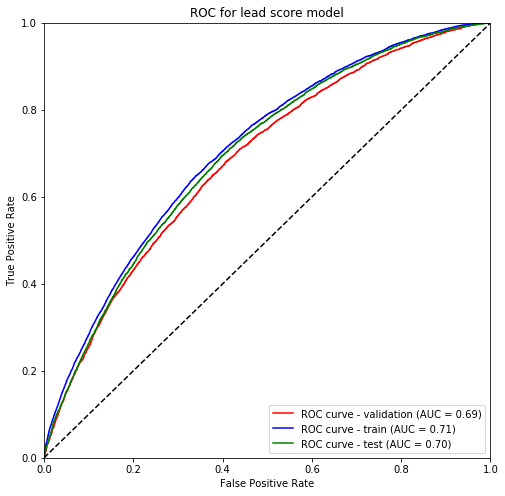

In [180]:
draw_ROC(xgb_model, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### (c) Distribution of predicted values

In [109]:
y_pred = xgb_model.predict(dtest)

In [110]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.549282 0.00962909 0.134195


### (d) Feature importance

In [147]:
import operator
importance = xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

In [149]:
df_importance = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [152]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
64,intrate,0.073633
63,annualinc,0.063114
62,installment,0.061711
61,dti,0.051192
60,accopenpast24mths,0.049088
59,subgrade,0.048387
58,mosinoldrevtlop,0.036466
57,avgcurbal,0.032959
56,totalbclimit,0.026648
55,emptitle_freq,0.024544


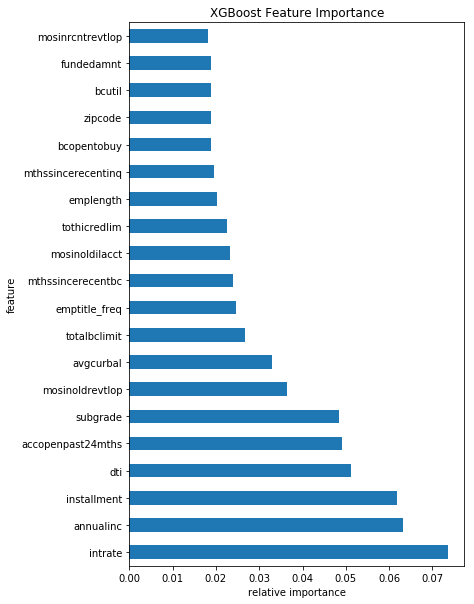

In [153]:
plt.figure(figsize=(32, 32))
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [154]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
26,grade,0.008415


In [155]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
59,subgrade,0.048387


In [156]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
64,intrate,0.073633


Text(0.5,0,'relative importance')

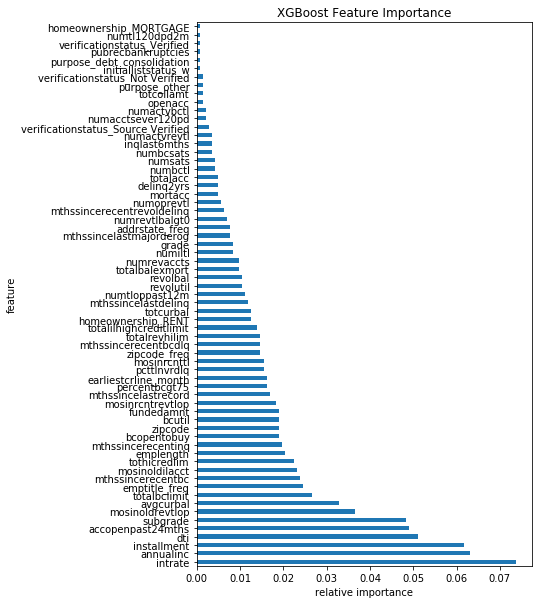

In [158]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

### (e) Save model

In [159]:
import pickle

In [161]:
pickle.dump(xgb_model, open('model.pkl', "wb"))

In [163]:
from sklearn.externals import joblib
joblib.dump(xgb_model, "pima.joblib.dat")

['pima.joblib.dat']

In [165]:
with open('model.pkl', 'wb') as outfile:
    pickle.dump(xgb_model, outfile)